# Advanced pyALF part 2: Postprocessing

In [72]:
from py_alf import utils

In [73]:
dirs = utils.find_sim_dirs()
dirs

['./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5',
 './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.0',
 './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.5',
 './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=4.0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2',
 './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_b

## Custom observables

In [74]:
import numpy as np

Correlation ratio 
$1 - \frac{O(\mathbf{k}+\mathbf{\delta})}{\mathbf{k}}$. RG-invariant quantity

In [4]:
def R_k(obs, back, sign, N_orb, N_tau, dtau, latt,
        ks=[(0., 0.)], mat=None, NNs=[(1, 0), (0, 1), (-1, 0), (0, -1)]):
    """RG-invariant quantity derived from a correlatian function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    if mat is None:
        mat = np.identity(N_orb)
    out = 0
    for k in ks:
        n = latt.k_to_n(k)

        J1 = (obs[..., n].sum(axis=-1) * mat).sum()
        J2 = 0
        for NN in NNs:
            i = latt.nnlistk[n, NN[0], NN[1]]
            J2 += (obs[..., i].sum(axis=-1) * mat).sum() / len(NNs)
        out += (1 - J2/J1)

    return out / len(ks)

Binder cumulant $\left(3 - \frac{\langle s^4 \rangle}{\langle s^2 \rangle^2}\right)/2$. RG-invariant quantity

In [5]:
def binder(obs, sign, N_obs):
    return (3 - obs[2] / obs[1]**2)/2 / sign

Susceptibility $\int_{0}^{\beta}\!\text{d}\tau\, C\left(\mathbf{k},\tau\right)$

In [6]:
def susceptibility(obs, back, sign, N_orb, N_tau, dtau, latt,
                   ks=[[0., 0.]]):
    """Susceptibility of a time-displaced correlatian function.
    
    obs.shape = (N_orb, N_orb, N_tau, latt.N)
    back.shape = (N_orb,)
    """
    out = 0
    for k in ks:
        n = latt.k_to_n(k)
        out += dtau*obs[..., n].trace().sum() / sign
    return out / len(ks)

In [7]:
custom_obs = {}

In [22]:
custom_obs['R_S']= {
    'needs': ['IsingZ_eq'],
    'function': R_k,
    'kwargs': {}
}

custom_obs['R_chi']= {
    'needs': ['IsingZT_tau'],
    'function': R_k,
    'kwargs': {}
}

custom_obs['B']= {
    'needs': ['m_scal'],
    'function': binder,
    'kwargs': {}
}

custom_obs['chi']= {
    'needs': ['IsingZT_tau'],
    'function': susceptibility,
    'kwargs': {}
}

## Check warmup and autocorrelation

In [75]:
# Enable Jupyter Widget support for matplotlib
%matplotlib widget

In [76]:
from py_alf import check_warmup, check_rebin

In [77]:
check_warmup(dirs, ['m_scal', 'ising_x_scal', 'R', 'B', 'chi'], custom_obs=custom_obs, gui='ipy')

In [78]:
check_rebin(dirs, ['m_scal', 'ising_x_scal', 'R', 'B', 'chi'], custom_obs=custom_obs, gui='ipy')

## Symmetrize correlation functions

In [79]:
from math import pi

# Define list of transformations (Lattice, i) -> new_i
# Default analysis will average over all listed elements
def sym_c2_0(latt, i): return i
def sym_c2_1(latt, i): return latt.rotate(i, pi)

symmetry = [sym_c2_0, sym_c2_1]

## Error analysis

In [25]:
from py_alf import analysis  # The function behind Simulation.analysis

In [50]:
for directory in dirs:
    analysis(directory, custom_obs=custom_obs, symmetry=symmetry, always=True)

### Analyzing ./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5 ###
/scratch/Nematic_example
Custom observables:
custom R ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
custom R_S ['IsingZ_eq']
Scalar observables:
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time observables:
Green_eq
IsingX_eq
IsingZ_eq
Time displaced observables:
Green_tau
IsingXT_tau
IsingZT_tau
### Analyzing ./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.0 ###
/scratch/Nematic_example
Custom observables:
custom R ['IsingZ_eq']
custom R_chi ['IsingZT_tau']
custom B ['m_scal']
custom chi ['IsingZT_tau']
custom R_S ['IsingZ_eq']
Scalar observables:
Kin_Pot_E_scal
Part_scal
chi2_scal
ising_x_alt_scal
ising_x_scal
ising_z_alt_scal
ising_z_scal
m_alt_scal
m_scal
Histogram observables:
B_hist
X_hist
m_hist
Equal time ob

In [80]:
from py_alf.ana import load_res  # The function behind Simulation.get_obs

In [81]:
res = load_res(dirs)

./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.0
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.5
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=4.0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_2
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_3
./ALF_data/tempe

In [52]:
res

,beta,dtau,global_h,global_j,global_type,ham_chem,ham_h,ham_j,ham_t,ham_xi,...,IsingXT_tau_lattice,IsingZT_tauK,IsingZT_tauK_err,IsingZT_tauR,IsingZT_tauR_err,IsingZT_tau_lattice,Acc_Temp_scal_sign,Acc_Temp_scal_sign_err,Acc_Temp_scal0,Acc_Temp_scal0_err
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5,16.0,0.1,3.0,1.0,b'',0.0,2.5,1.0,1.0,0.25,...,"{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.37108796178100045, 0.4398449507263387, 0.3...","[[0.0013381653551744982, 0.0021026724561773935...","[[0.6231987987949656, 0.64738106027726, 0.6237...","[[0.0011247302922614726, 0.0010468745598024682...","{'L1': [2.82842712474619, 2.82842712474619], '...",NaN,NaN,NaN,NaN
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.0,16.0,0.1,3.0,1.0,b'',0.0,3.0,1.0,1.0,0.25,...,"{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.5443260585894176, 0.700533731323807, 0.544...","[[0.0018845385717756156, 0.0029078087826284083...","[[0.4380695830886671, 0.4844834279376261, 0.43...","[[0.0014773586803796938, 0.001269662036100306,...","{'L1': [2.82842712474619, 2.82842712474619], '...",NaN,NaN,NaN,NaN
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.5,16.0,0.1,3.0,1.0,b'',0.0,3.5,1.0,1.0,0.25,...,"{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.7164601508542349, 0.9719713985124285, 0.71...","[[0.0020605849299433596, 0.003382610253592149,...","[[0.25392371305539246, 0.3273849893744932, 0.2...","[[0.001349184053817978, 0.0012000630011568415,...","{'L1': [2.82842712474619, 2.82842712474619], '...",NaN,NaN,NaN,NaN
./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=4.0,16.0,0.1,3.0,1.0,b'',0.0,4.0,1.0,1.0,0.25,...,"{'L1': [2.82842712474619, 2.82842712474619], '...","[[0.8271356796829125, 1.1373960290663532, 0.82...","[[0.002361860665400648, 0.003016297399114026, ...","[[0.13593076556077505, 0.2252957648267761, 0.1...","[[0.001267023567620155, 0.0010193887281788599,...","{'L1': [2.82842712474619, 2.82842712474619], '...",NaN,NaN,NaN,NaN
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0,40.0,0.1,3.0,1.0,b'',0.0,2.5,1.0,1.0,0.25,...,"{'L1': [7.071067811865475, 7.071067811865475],...","[[0.32684775541242644, 0.3451148345945538, 0.3...","[[0.0013700078487058523, 0.0010326952902467601...","[[0.5769109397572272, 0.5772670122438199, 0.57...","[[0.0006607760466393276, 0.0006546627621952326...","{'L1': [7.071067811865475, 7.071067811865475],...",1.0,0.0,0.0,0.0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1,40.0,0.1,3.0,1.0,b'',0.0,3.0,1.0,1.0,0.25,...,"{'L1': [7.071067811865475, 7.071067811865475],...","[[0.46595924296459373, 0.49906530502317414, 0....","[[0.001876549282471484, 0.002105426589611929, ...","[[0.316119642175926, 0.31701610172595707, 0.31...","[[0.0009222844613126438, 0.0011166679766716964...","{'L1': [7.071067811865475, 7.071067811865475],...",1.0,0.0,0.0,0.0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2,40.0,0.1,3.0,1.0,b'',0.0,3.5,1.0,1.0,0.25,...,"{'L1': [7.071067811865475, 7.071067811865475],...","[[0.5923744976077365, 0.6427467860781865, 0.72...","[[0.002430582558504435, 0.002857598793904322, ...","[[0.03708787202241348, 0.03971556684811598, 0....","[[0.0013644858157791941, 0.001109037932313041,...","{'L1': [7.071067811865475, 7.071067811865475],...",1.0,0.0,0.0,0.0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3,40.0,0.1,3.0,1.0,b'',0.0,4.0,1.0,1.0,0.25,...,"{'L1': [7.071067811865475, 7.071067811865475],...","[[0.6327167868615791, 0.6893288891413505, 0.78...","[[0.002262407849196341, 0.003976052986235357, ...","[[0.0025783470514712968, 0.0033798829826296914...","[[0.0004446529224489861, 0.0004152782737582877...","{'L1': [7.071067811865475, 7.071067811865475],...",1.0,0.0,0.0,0.0
./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0,24.0,0.1,3.0,1.0,b'',0.0,2.

## Plot order parameter

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0, 0.5, '$S(\\mathbf{k}=0)$')

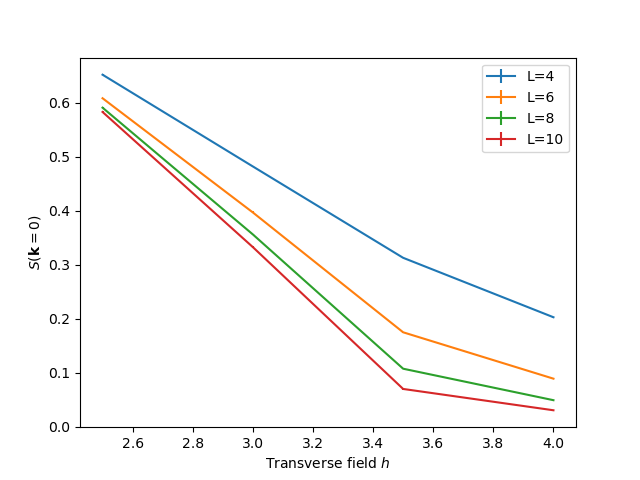

In [83]:
fig, ax = plt.subplots()
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    ax.errorbar(df.ham_h, df.m_scal0, df.m_scal0_err, label=f'L={L}')
ax.legend()
ax.set_xlabel('Transverse field $h$')
ax.set_ylabel('$S(\mathbf{k}=0)$')


## Plot RG-invariant quantities

RG-invariant quantities behave at critical point as:
$$
R = f(L^z/\beta, (h-h_c)L^{1/\nu}, L^{-\omega})
$$
Dismissing dependence on $\beta$ and finite size corrections:
$$
R = f((h-h_c)L^{1/\nu})
$$

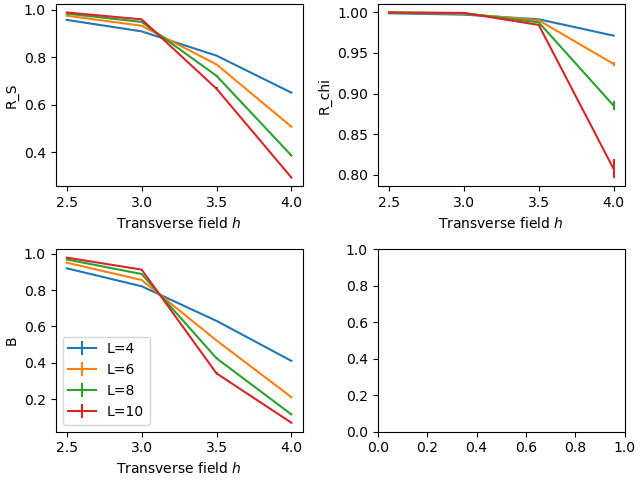

In [84]:
fig, axs = plt.subplots(2, 2, constrained_layout=True)
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ax in zip(['R_S', 'R_chi', 'B'],
                            axs.flat):
        ax.errorbar(df.ham_h, df[obs_name], df[obs_name+'_err'], label=f'L={L}')
        ax.set_xlabel('Transverse field $h$')
        ax.set_ylabel(obs_name)
ax.legend()

## Attempting data collapse

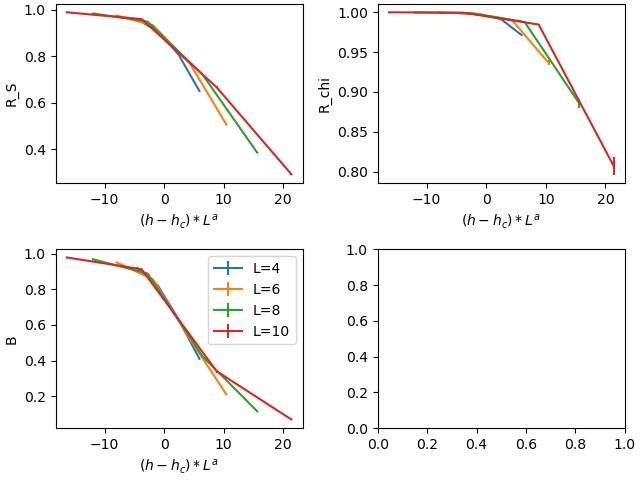

In [85]:
hc = 3.15
a = 1.4
fig, axs = plt.subplots(2, 2, constrained_layout=True)
for L in [4, 6, 8, 10]:
    df = res[res.l1 == L].sort_values(by='ham_h')
    for obs_name, ax in zip(['R_S', 'R_chi', 'B'],
                            axs.flat):
        ax.errorbar((df.ham_h-hc)*L**a, df[obs_name], df[obs_name+'_err'], label=f'L={L}')
        ax.set_xlabel('$(h-h_c)*L^a$')
        ax.set_ylabel(obs_name)
ax.legend()

## Plot correlation

### Accessing elemts of the dataframe

In [57]:
for i in res:
    print(i)

beta
dtau
global_h
global_j
global_type
ham_chem
ham_h
ham_j
ham_t
ham_xi
ham_xi2
init_type
l1
l2
model_vers
n_sun
phi_1
phi_2
R
R_err
R_chi
R_chi_err
B
B_err
chi
chi_err
R_S
R_S_err
Kin_Pot_E_scal_sign
Kin_Pot_E_scal_sign_err
Kin_Pot_E_scal0
Kin_Pot_E_scal0_err
Kin_Pot_E_scal1
Kin_Pot_E_scal1_err
Kin_Pot_E_scal2
Kin_Pot_E_scal2_err
Part_scal_sign
Part_scal_sign_err
Part_scal0
Part_scal0_err
chi2_scal_sign
chi2_scal_sign_err
chi2_scal0
chi2_scal0_err
chi2_scal1
chi2_scal1_err
ising_x_alt_scal_sign
ising_x_alt_scal_sign_err
ising_x_alt_scal0
ising_x_alt_scal0_err
ising_x_scal_sign
ising_x_scal_sign_err
ising_x_scal0
ising_x_scal0_err
ising_z_alt_scal_sign
ising_z_alt_scal_sign_err
ising_z_alt_scal0
ising_z_alt_scal0_err
ising_z_scal_sign
ising_z_scal_sign_err
ising_z_scal0
ising_z_scal0_err
m_alt_scal_sign
m_alt_scal_sign_err
m_alt_scal0
m_alt_scal0_err
m_alt_scal1
m_alt_scal1_err
m_alt_scal2
m_alt_scal2_err
m_scal_sign
m_scal_sign_err
m_scal0
m_scal0_err
m_scal1
m_scal1_err
m_scal2
m_s

In [53]:
res.index

Index(['./ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=2.5',
       './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.0',
       './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=3.5',
       './ALF_data/Nematic_Dirac_Model_vers=1_L1=4_L2=4_beta=16.0_xi=0.25_h=4.0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_2',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_0',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/Temp_1',
       './ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=6_L2=6_beta=24.0_xi=0.25_h=2.5/T

In [55]:
item = res.loc['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0']
item

beta                                                                   40.0
dtau                                                                    0.1
global_h                                                                3.0
global_j                                                                1.0
global_type                                                             b''
                                                ...                        
IsingZT_tau_lattice       {'L1': [7.071067811865475, 7.071067811865475],...
Acc_Temp_scal_sign                                                      1.0
Acc_Temp_scal_sign_err                                                  0.0
Acc_Temp_scal0                                                          0.0
Acc_Temp_scal0_err                                                      0.0
Name: ./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_0, Length: 127, dtype: object

In [67]:
item['IsingZ_eqK'].shape

(1, 1, 100)

In [66]:
item['IsingZ_eqK']

array([[[ 0.32639736,  0.3458985 ,  0.37577835,  0.40525336,
          0.41845474,  0.40567847,  0.37577562,  0.34583914,
          0.32671372,  0.32000854,  0.34579546,  0.36957212,
          0.40547876,  0.44294379,  0.45991551,  0.44249498,
          0.40537165,  0.36937979,  0.34591759,  0.33731339,
          0.37374582,  0.40442965,  0.45241449,  0.50663498,
          0.5322112 ,  0.5063928 ,  0.45333288,  0.40456063,
          0.37436874,  0.36385721,  0.40217166,  0.43916906,
          0.50477977,  0.58192395,  0.62261337,  0.58166522,
          0.50321708,  0.44019047,  0.40257657,  0.38972385,
          0.41560679,  0.45571551,  0.52824801,  0.62147615,
         58.38348744,  0.62147615,  0.52824801,  0.45571551,
          0.41560679,  0.40162511,  0.40257657,  0.44019047,
          0.50321708,  0.58166522,  0.62261337,  0.58192395,
          0.50477977,  0.43916906,  0.40217166,  0.38972385,
          0.37436874,  0.40456063,  0.45333288,  0.5063928 ,
          0.5322112 ,  0

### Creating Lattice object

In [62]:
from py_alf import Lattice

In [63]:
latt = Lattice(item['IsingZ_eq_lattice'])

In [64]:
latt.k

array([[-3.55430635,  0.        ],
       [-3.11001806, -0.44428829],
       [-2.66572976, -0.88857659],
       [-2.22144147, -1.33286488],
       [-1.77715318, -1.77715318],
       [-1.33286488, -2.22144147],
       [-0.88857659, -2.66572976],
       [-0.44428829, -3.11001806],
       [ 0.        , -3.55430635],
       [ 0.44428829, -3.99859464],
       [-3.11001806,  0.44428829],
       [-2.66572976,  0.        ],
       [-2.22144147, -0.44428829],
       [-1.77715318, -0.88857659],
       [-1.33286488, -1.33286488],
       [-0.88857659, -1.77715318],
       [-0.44428829, -2.22144147],
       [ 0.        , -2.66572976],
       [ 0.44428829, -3.11001806],
       [ 0.88857659, -3.55430635],
       [-2.66572976,  0.88857659],
       [-2.22144147,  0.44428829],
       [-1.77715318,  0.        ],
       [-1.33286488, -0.44428829],
       [-0.88857659, -0.88857659],
       [-0.44428829, -1.33286488],
       [ 0.        , -1.77715318],
       [ 0.44428829, -2.22144147],
       [ 0.88857659,

### Plot Spin-Spin correlation deep in odered phase

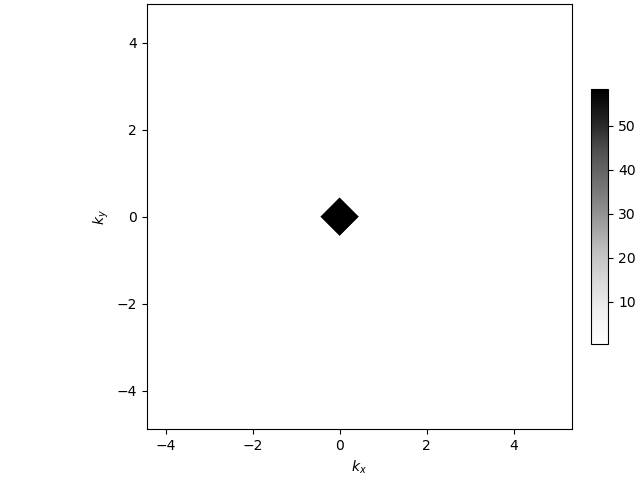

In [70]:
latt.plot_k(item['IsingZ_eqK'][0,0])

### Plot Spin-Spin correlation in disodered phase

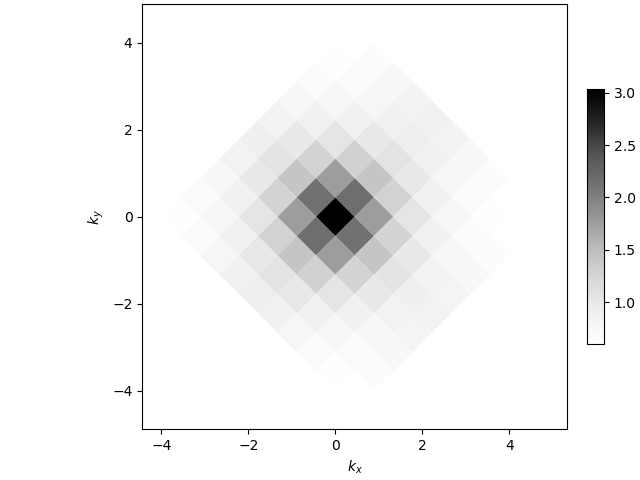

In [71]:
latt.plot_k(res.loc['./ALF_data/temper_Nematic_Dirac_Model_vers=1_L1=10_L2=10_beta=40.0_xi=0.25_h=2.5/Temp_3']['IsingZ_eqK'][0,0])